In [1]:
import matplotlib.pyplot as plt 
import torch 
import torchvision

from torch import nn
from torchvision import transforms 
print("imported")

imported


In [2]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
#set up
train_dir="/kaggle/input/casia-zipped/CASIA2.0_revised/Training"
test_dir="/kaggle/input/casia-zipped/CASIA2.0_revised/Testing"

In [4]:
import os 
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader 


NUM_WORKERS=os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str, 
    transform: transforms.Compose,
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
    #using imagefolders to create datasets 
    train_data=datasets.ImageFolder(train_dir, transform=transform)
    test_data=datasets.ImageFolder(test_dir, transform=transform)
    
    
    #getting class names 
    class_names=train_data.classes
    
    #turning images into data loaders 
    train_dataloader=DataLoader(
        train_data, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    test_dataloader=DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_dataloader, test_dataloader, class_names








In [5]:
#create image size 
IMG_SIZE=224
#creating transform pipeline manually 
manual_transforms=transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")
#resized the images and converted them into tensors


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
#creating image size 
BATCH_SIZE=32

#creating data loaders 
train_dataloader, test_dataloader, class_names=create_dataloaders(
    train_dir=train_dir, 
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)


train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ae0140fdc00>,
 ['Authentic', 'Forged'])

torch.Size([3, 224, 224]) tensor(0)


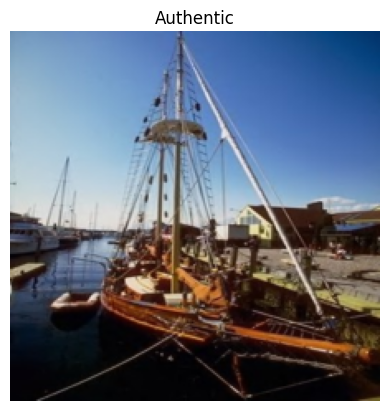

In [7]:
#getting a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)
    
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

steps:
1. turning images into patches 
2. flatten the patch feature maps into a single dimension 
3. convert the output into desired output (flattened 2D patches)

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768):
        #in_channels is 3 because it is an RGB image - three channels 
        #patch_size is 16, following the originial prescribed number
        #embedding dimension - 16*16*3 
        super().__init__()
        #the below is used to convert an image into its patches 
        self.patcher = nn.Conv2d(in_channels=in_channels, #input image dimensions 
                                 out_channels=embedding_dim, #output image desired dimensions 
                                 kernel_size=patch_size, #kernel is like filter 
                                 stride=patch_size, #the filters don't overlap 
                                 padding=0)
        # Remove the flatten operation from __init__
        # self.flatten = torch.flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch_size: {patch_size}"
        
        x_patched = self.patcher(x)
        # Apply flatten operation here
        x_flattened = torch.flatten(x_patched, start_dim=2, end_dim=3)
        
        return x_flattened.permute(0, 2, 1)
    
#desired output is (196,768). basically converting the input images into 1D vectors with 768 values each 

In [9]:
#testing it on a single image 
patch_size=16 

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seeds()

patchify=PatchEmbedding(in_channels=3,
                       patch_size=16, 
                       embedding_dim=768)

#passing a single image through 
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image=patchify(image.unsqueeze(0))
print(f"Output patch embedding shape : {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape : torch.Size([1, 196, 768])


In [10]:
#viewing the patch embedding and patch embedding shape 
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape}->[batch_size, number_of_patches, embedding_dimension]")

#in the output, we'll have 196 different patches, and each one will have 768 different values 

tensor([[[-0.6158,  0.2114, -0.2422,  ...,  0.5171, -0.2293,  0.2082],
         [-0.5888,  0.2016, -0.2403,  ...,  0.5082, -0.2300,  0.2095],
         [-0.5771,  0.1958, -0.2331,  ...,  0.5044, -0.2219,  0.1991],
         ...,
         [-0.0613, -0.0139, -0.0255,  ...,  0.0411, -0.0311, -0.0307],
         [-0.0299, -0.0057, -0.0386,  ...,  0.0482, -0.0247,  0.0259],
         [-0.1878, -0.0229, -0.0629,  ...,  0.0697, -0.0261,  0.0335]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768])->[batch_size, number_of_patches, embedding_dimension]


till now, we have done linear projection of the images. Now the task is to add class embedding and then to add position embedding. 

In [11]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
#adding a batch dimension allows you to process multiple images parallely 
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)
#this allows the transformer model to process the images, similar tokens in nlp 
#the patch embedding is for examining the local features

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

#class token is for looking at the entire image to identify features.
#class token is used to gather info from all patches and make a decision 

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable
#we have to do this because the patches get jumbled, so we have to number them in order to understand the image. 


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])


Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6158,  0.2114, -0.2422,  ...,  0.5171, -0.2293,  0.2082],
         [-0.5888,  0.2016, -0.2403,  ...,  0.5082, -0.2300,  0.2095],
         ...,
         [-0.0613, -0.0139, -0.0255,  ...,  0.0411, -0.0311, -0.0307],
         [-0.0299, -0.0057, -0.0386,  ...,  0.0482, -0.0247,  0.0259],
         [-0.1878, -0.0229, -0.0629,  ...,  0.0697, -0.0261,  0.0335]]],
       grad_fn=<CatBackward0>)


The above code did three things:
1. Create patch embeddings - this examines local features 
2. class tokens -they are for the global features 
3. position embedding - they are used to number the patches because patches get jumbled and we need to be able to sort them out 

In [12]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, #used this value in the original ViT paper 
                 attn_dropout:float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x, 
                                             need_weights=False)
        return attn_output

1. Layer normalization is used to put all the images into a range 
2. multi head self attention - focuses on diff parts of the images at the same time 
3. embedding dimension - token information 
4. number of heads - looking at the same piece of text from different angels
5. dropout - to reduce overfitting 

In [13]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072, 
                 dropout:float=0.1): 
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Multi layer perceptron - linear transformation, dropout, linear transformation, dropout. 

In [14]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    
    def forward(self, x):
        x =  self.msa_block(x) + x 
        x = self.mlp_block(x) + x 
        
        return x

In [15]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [16]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000): 
        super().__init__() 
        
        
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    

    def forward(self, x):
        

        batch_size = x.shape[0]
        

        class_token = self.class_embedding.expand(batch_size, -1, -1)


        x = self.patch_embedding(x)


        x = torch.cat((class_token, x), dim=1)


        x = self.position_embedding + x


        x = self.embedding_dropout(x)


        x = self.transformer_encoder(x)


        x = self.classifier(x[:, 0])

        return x 

In [17]:
vit = ViT(num_classes=len(class_names))

In [18]:
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer.git


Cloning into 'Image-Classification-Using-Vision-transformer'...


remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.


remote: Total 43 (delta 12), reused 8 (delta 8), pack-reused 29
Unpacking objects: 100% (43/43), 862.12 KiB | 3.20 MiB/s, done.


In [19]:
%cd Image-Classification-Using-Vision-transformer/going_modular/


/kaggle/working/Image-Classification-Using-Vision-transformer/going_modular


In [20]:
!cp -r going_modular /kaggle/working/


In [21]:
import torch
from torch.nn.utils import clip_grad_norm_
from going_modular import engine

optimizer = torch.optim.SGD(params=vit.parameters(),
                            lr=1e-4,
                            momentum=0.9,
                            weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data).item()
    accuracy = corrects / labels.size(0)
    return accuracy

def train_with_gradient_clipping(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, clip_value=1.0):
    model.to(device)  # Move model to device
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_dataloader.dataset)
        train_accuracy = correct_train / total_train

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_dataloader.dataset)
        test_accuracy = correct_test / total_test
        
        # Store the results
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f'Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

        if epoch + 1 == 50:
            # Save the model after 50 epochs
            torch.save(model.state_dict(), 'vit_model.pth')

    return train_losses, test_losses, train_accuracies, test_accuracies

train_losses, test_losses, train_accuracies, test_accuracies = train_with_gradient_clipping(model=vit,
                                                                                            train_dataloader=train_dataloader,
                                                                                            test_dataloader=test_dataloader,
                                                                                            optimizer=optimizer,
                                                                                            loss_fn=loss_fn,
                                                                                            epochs=100,
                                                                                            device=device,
                                                                                            clip_value=1.0)


Epoch: 1/100, Train Loss: 0.6055, Test Loss: 0.5932, Train Accuracy: 0.7078, Test Accuracy: 0.7086


### torch.load('vit_model.pth')

In [ ]:
# Check if the model file exists
if os.path.exists('vit_model.pth'):
    # Load the saved model
    loaded_model = vit
    loaded_model.load_state_dict(torch.load('vit_model.pth'))
    loaded_model.eval()

    # Move the model to the device
    loaded_model.to(device)

    # Plotting the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    # Plotting the training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

In [ ]:
model=ViT()
print("The state dict keys: \n\n", model.state_dict().keys())

In [ ]:
import torch
from torch.nn.utils import clip_grad_norm_
from going_modular import engine
import os

optimizer = torch.optim.SGD(params=vit.parameters(),
                            lr=1e-4,
                            momentum=0.9,
                            weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data).item()
    accuracy = corrects / labels.size(0)
    return accuracy

def train_with_gradient_clipping(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, clip_value=1.0):
    model.to(device)  # Move model to device
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_dataloader.dataset)
        train_accuracy = correct_train / total_train

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_dataloader.dataset)
        test_accuracy = correct_test / total_test
        
        # Store the results
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f'Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

        # Save the model after every epoch to the output directory
        save_path = f'/kaggle/working/vit_model_epoch_{epoch+1}.pth'
        try:
            torch.save(model.state_dict(), save_path)
            print(f"Model saved successfully at {save_path}")
        except Exception as e:
            print(f"Error occurred while saving the model: {e}")

    return train_losses, test_losses, train_accuracies, test_accuracies

train_losses, test_losses, train_accuracies, test_accuracies = train_with_gradient_clipping(model=vit,
                                                                                            train_dataloader=train_dataloader,
                                                                                            test_dataloader=test_dataloader,
                                                                                            optimizer=optimizer,
                                                                                            loss_fn=loss_fn,
                                                                                            epochs=1,
                                                                                            device=device,
                                                                                            clip_value=1.0)


In [ ]:
import os

output_dir = '/kaggle/working/'
files = os.listdir(output_dir)
print(files)
